### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------

Stephen Law, Igor Tkalec, Thomas Keel, and Gong Jie

For this second task, we would like you to analyse a dataset that contains review data of different venues in the city of Calgary,
Canada. With the help of several machine learning techniques that we have learnt in the course, you will be tasked to distill
insights from this social media dataset. Two of its notable features are the geocoding of every reviewed venues and the
availability of a considerable amount of text data in it, which lend to its ability to be processed using spatial and text analysis
techniques respectively.

As a prelude to the analysis prompts below, have a brief think about some of these questions: What can we discover about the
venue review data? Are there any spatial patterns that can be extracted from the data? Can we build a machine learning model
that predicts review rating for unseen data points using the text of the reviews?

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

In [304]:
#importing necessary packages for this project

##data managament

import numpy as np #for numeric calculations with more complex data structures
import pandas as pd #for data importing, wrangling and cleaning

##data visualisation

import matplotlib.pyplot as plt #for plots and data visualisation
import seaborn as sns #for plots and data visualisation
import geopandas as gpd #for geospatial data management and mapping
import contextily as ctx #for retrieving basemaps from the internet
import scipy.stats #shapiro-wilk test for normality
from scipy.stats import norm #for normal distribution curve



##feature engineering

from scipy.stats import skew #check for skewness
from sklearn.preprocessing import StandardScaler #standard scaler of variables

##analysis

from sklearn.model_selection import train_test_split #splitting dataset into train and split before modelling
from sklearn import metrics #metics
from sklearn.model_selection import cross_validate #cross validation
from sklearn.model_selection import GridSearchCV #grid search
from sklearn.model_selection import RandomizedSearchCV # randomized search
from sklearn.model_selection import KFold #kfold
from sklearn.feature_selection import RFE #rfe

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud


##ignore warnings

import warnings
warnings.filterwarnings(action='ignore')

## 1. Data Importing

In [305]:
calgary = pd.read_csv("Data/Calgary.csv")
calgary.head()

business_id                            name  latitude  \
0  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
1  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
2  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
3  rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.08499   
4  rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.08499   

    longitude  review_count  \
0 -114.037207             3   
1 -114.037207             3   
2 -114.037207             3   
3 -113.989605             5   
4 -113.989605             5   

                                          categories  \
0            Contractors, Landscaping, Home Services   
1            Contractors, Landscaping, Home Services   
2            Contractors, Landscaping, Home Services   
3  Shopping, Caterers, Furniture Stores, Hot Tub ...   
4  Shopping, Caterers, Furniture Stores, Hot Tub ...   

                                               hours               review_id  \
0  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  pltqT0DnejbWN-K32BD1Fg   
1  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  8Iaf1YXNjo3zPd6-uLSJhg   
2  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  fTU0yYLj78NJftEKah-woQ   
3  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...  2SGfqlKDjuFpXZ7LjdNJSQ   
4  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...  5RfnOMsGcQ26EoXlteFOyw   

                  user_id  stars_y  useful  funny  cool  \
0  v6zuRbp5jjHroawRiv9IhQ      5.0       1      0     0   
1  UkL35C-EXA_yje4HeNINeQ      5.0       0      0     0   
2  CXhdG2DP0aplOZPZtNFobw      5.0       0      0     0   
3  siNu6MF02MSMnoyPkaxZyg      5.0       5      0     0   
4  -InhDRRVG7wrwsgAUvN4Qw      5.0       6      3     3   

                                                text                 date  
0  David came in the spring to give me an estimat...  2017-08-16 01:10:52  
1  Chinook Landscaping is a Company that I would ...  2014-06-15 21:09:06  
2  Chinook Landscaping is tops in my book\nI was ...  2013-08-22 22:10:38  
3  If you are looking for a supplier of games tab...  2009-06-29 02:20:25  
4  SML is now a personal wet dream of mine, the e...  2009-12-03 17:29:51

In [306]:
calgary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82182 entries, 0 to 82181
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   82182 non-null  object 
 1   name          82182 non-null  object 
 2   latitude      82182 non-null  float64
 3   longitude     82182 non-null  float64
 4   review_count  82182 non-null  int64  
 5   categories    82182 non-null  object 
 6   hours         82182 non-null  object 
 7   review_id     82182 non-null  object 
 8   user_id       82182 non-null  object 
 9   stars_y       82182 non-null  float64
 10  useful        82182 non-null  int64  
 11  funny         82182 non-null  int64  
 12  cool          82182 non-null  int64  
 13  text          82182 non-null  object 
 14  date          82182 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 9.4+ MB


## 2. Data Wrangling and Exploration

In [307]:
#number of rows and columns in property dataset

calgary.shape

(82182, 15)

#### 2.1.1 Descriptive Statistics of London Housing Dataset

In [308]:
#have a look at descriptive statistics of property data
calgary.describe().T

count        mean        std         min         25%  \
latitude      82182.0   51.042724   0.051552   50.865169   51.033200   
longitude     82182.0 -114.070648   0.053040 -114.379523 -114.086896   
review_count  82182.0   61.995254  77.290191    3.000000   13.000000   
stars_y       82182.0    3.618639   1.424214    1.000000    3.000000   
useful        82182.0    1.293203   2.830347    0.000000    0.000000   
funny         82182.0    0.391083   1.306604    0.000000    0.000000   
cool          82182.0    0.382578   1.171075    0.000000    0.000000   

                     50%         75%        max  
latitude       51.044727   51.066428   51.20754  
longitude    -114.070254 -114.053056 -113.71414  
review_count   36.000000   78.000000  512.00000  
stars_y         4.000000    5.000000    5.00000  
useful          0.000000    2.000000  104.00000  
funny           0.000000    0.000000   59.00000  
cool            0.000000    0.000000   69.00000

In [309]:
#checking for duplicates
calgary.duplicated().value_counts()

False    82182
dtype: int64

In [310]:
calgary.drop_duplicates(inplace=True)

In [311]:
calgary.isnull().value_counts()

business_id  name   latitude  longitude  review_count  categories  hours  review_id  user_id  stars_y  useful  funny  cool   text   date 
False        False  False     False      False         False       False  False      False    False    False   False  False  False  False    82182
dtype: int64

In [312]:
calgary["text"].isnull().value_counts()

False    82182
Name: text, dtype: int64

In [313]:
calgary['column1'] = calgary['categories'].str.split(', ').str[0]
calgary['column2'] = calgary['categories'].str.split(', ').str[1]
calgary['column3'] = calgary['categories'].str.split(', ').str[2]
calgary['column4'] = calgary['categories'].str.split(', ').str[3]



calgary


business_id                            name   latitude  \
0      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
1      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
2      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
3      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
4      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
...                       ...                             ...        ...   
82177  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82178  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82179  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82180  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82181  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   

        longitude  review_count  \
0     -114.037207             3   
1     -114.037207             3   
2     -114.037207             3   
3     -113.989605             5   
4     -113.989605             5   
...           ...           ...   
82177 -114.066646             3   
82178 -114.066646             3   
82179 -114.012717             3   
82180 -114.012717             3   
82181 -114.012717             3   

                                              categories  \
0                Contractors, Landscaping, Home Services   
1                Contractors, Landscaping, Home Services   
2                Contractors, Landscaping, Home Services   
3      Shopping, Caterers, Furniture Stores, Hot Tub ...   
4      Shopping, Caterers, Furniture Stores, Hot Tub ...   
...                                                  ...   
82177                       Pest Control, Local Services   
82178                       Pest Control, Local Services   
82179                     Home Services, Home Inspectors   
82180                     Home Services, Home Inspectors   
82181                     Home Services, Home Inspectors   

                                                   hours  \
0      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
1      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
2      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
3      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
4      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
...                                                  ...   
82177  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82178  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82179  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82180  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82181  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   

                    review_id                 user_id  stars_y  useful  funny  \
0      pltqT0DnejbWN-K32BD1Fg  v6zuRbp5jjHroawRiv9IhQ      5.0       1      0   
1      8Iaf1YXNjo3zPd6-uLSJhg  UkL35C-EXA_yje4HeNINeQ      5.0       0      0   
2      fTU0yYLj78NJftEKah-woQ  CXhdG2DP0aplOZPZtNFobw      5.0       0      0   
3      2SGfqlKDjuFpXZ7LjdNJSQ  siNu6MF02MSMnoyPkaxZyg      5.0       5      0   
4      5RfnOMsGcQ26EoXlteFOyw  -InhDRRVG7wrwsgAUvN4Qw      5.0       6      3   
...                       ...                     ...      ...     ...    ...   
82177  pd7i8sxkMfbjdWR926nz8Q  zYLF37lcx2MPIHZVJjahBA      5.0       1      1   
82178  Uu4txscaQB25tF5kuG4gkg  rlY-ah6vhTHiRkJMEtDJ-g      5.0       1      0   
82179  kooH5UmJ5k-8USDe03jI9Q  Id5k4kNeblkyQSuteVURGQ      1.0       6      0   
82180  2SUoFTckEOdGd1V7GpIvrg  grsdpOuwSdwN3ndafhfa9Q      1.0       3      0   
82181  _1cYlw_lCkStn-RXH2DIbw  5Hs29y5fO7a6ZXWQmUbPaw      1.0       0      0   

       cool                                               text  \
0         0  David came in the spring to give me an estimat...   
1         0  Chinook Landscaping is a Company that I would ...   
2         0  Chinook Landscaping is tops in my book\nI was ...   
3    

In [314]:
calgary["column1"].value_counts()

Restaurants           14212
Food                   3769
Nightlife              2582
Bars                   2351
Canadian (New)         1766
                      ...  
Pain Management           3
Shaved Ice                3
Threading Services        3
Painters                  3
Radiologists              3
Name: column1, Length: 510, dtype: int64

In [315]:
calgary['year'] = calgary['date'].str[:4]

calgary_year =calgary.groupby(["year"])["stars_y"].agg(["count","mean"]).reset_index()
calgary_year


year  count      mean
0   2008    346  3.554913
1   2009   1476  3.783198
2   2010   2359  3.814328
3   2011   4323  3.668980
4   2012   5785  3.619360
5   2013   6090  3.485878
6   2014   7622  3.524534
7   2015  10052  3.586251
8   2016  11694  3.618864
9   2017  12024  3.666168
10  2018  11272  3.697835
11  2019   9139  3.561768

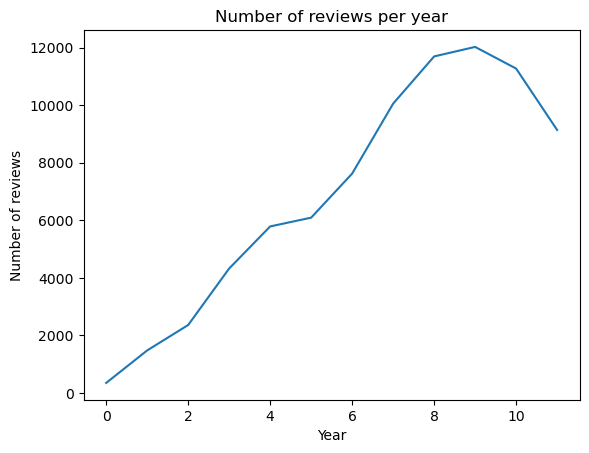

In [316]:

plt.plot(calgary_year['count'])
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per year')
plt.show()

In [317]:
calgary_grp =calgary.groupby(["business_id","name","column1","column2","column3","column4","latitude","longitude"])["stars_y"].agg(["count",min,max,"median","mean"]).reset_index()
calgary_grp

business_id                           name  \
0     --YPwqIlRJrhHkJcjY3eiA           That Old Retro Store   
1     -1u4Q4U6OZ-CvqoxUh7gKg                   Las Canarias   
2     -2C96suwzrE_cqI1U69cLA                    Open Sesame   
3     -3k6bAm0_xMD4CYQmH6xHA  Dalhousie Station Foot Clinic   
4     -6ISxWJBGYyI6JKA71rcPQ      Residential Leasing Group   
...                      ...                            ...   
3021  zrBDLK_FVfx3TubDuF-1JQ               Astra Automotive   
3022  zv_e5QK1tuWvJTITVM1PXQ    Mahogany Massage & Wellness   
3023  zwFScgZRXOsWnucfwyn8pw   Nottinghams Pub & Restaurant   
3024  zxT_TuVfr_7OgGdZNyIwyw                 Dublin Calling   
3025  zxl5OV08TBaEg43X3p7_Ng  Acclaim Hotel Calgary Airport   

                        column1               column2                 column3  \
0                 Vinyl Records              Shopping                   Books   
1                    Tapas Bars               Spanish      Tapas/Small Plates   
2                  Asian Fusion           Restaurants                Japanese   
3              Health & Medical       Medical Centers                 Doctors   
4           Property Management  Real Estate Services             Real Estate   
...                         ...                   ...                     ...   
3021                Auto Repair            Automotive     Transmission Repair   
3022           Health & Medical         Beauty & Spas         Massage Therapy   
3023                       Pubs           Restaurants  American (Traditional)   
3024                       Pubs             Irish Pub           Chicken Wings   
3025  Event Planning & Services              Airports         Hotels & Travel   

          column4   latitude   longitude  count  min  max  median      mean  
0            Mags  51.041015 -114.033419      3  1.0  4.0     1.0  2.000000  
1     Restaurants  51.037654 -114.088942     25  1.0  5.0     5.0  4.080000  
2       Nightlife  50.992148 -114.070811     74  1.0  5.0     4.0  3.445946  
3     Podiatrists  51.105195 -114.160208      4  4.0  5.0     5.0  4.750000  
4      Apartments  51.044711 -114.106434      4  1.0  5.0     1.0  2.000000  
...           ...        ...         ...    ...  ...  ...     ...       ...  
3021        Tires  50.997477 -114.060664      4  4.0  5.0     5.0  4.750000  
3022  Acupuncture  50.932756 -113.968063      5  1.0  5.0     4.0  3.200000  
3023      Burgers  51.116559 -114.204570     22  1.0  5.0     4.0  3.409091  
3024  Restaurants  51.038428 -114.141595      5  2.0  3.0     2.0  2.200000  
3025       Hotels  51.150411 -113.999658     24  1.0  5.0     4.0  3.875000  

[3026 rows x 13 columns]

In [318]:
calgary_grp["column1"].value_counts()

Restaurants                      189
Shopping                         149
Food                             103
Beauty & Spas                     74
Nightlife                         64
                                ... 
Street Vendors                     1
Drywall Installation & Repair      1
Pressure Washers                   1
Appliances & Repair                1
Fences & Gates                     1
Name: column1, Length: 460, dtype: int64

In [319]:
calgary_grp["column2"].value_counts()

Restaurants               228
Shopping                  146
Food                      101
Bars                       68
Home Services              60
                         ... 
Golf                        1
Moroccan                    1
Psychologists               1
Newspapers & Magazines      1
Signmaking                  1
Name: column2, Length: 463, dtype: int64

In [320]:
calgary_grp["column3"].value_counts()

Restaurants           225
Shopping              137
Food                  105
Bars                   71
Beauty & Spas          69
                     ... 
University Housing      1
Snow Removal            1
Greek                   1
Printing Services       1
Decks & Railing         1
Name: column3, Length: 458, dtype: int64

In [321]:
calgary_grp["column4"].value_counts()

Restaurants             197
Shopping                160
Food                    140
Nightlife                69
Automotive               55
                       ... 
Buses                     1
Pet Adoption              1
Commissioned Artists      1
African                   1
Martial Arts              1
Name: column4, Length: 445, dtype: int64

In [322]:
restaurants = calgary_grp.loc[(calgary_grp.column1=='Restaurants') | (calgary_grp.column2=='Restaurants') | (calgary_grp.column3=='Restaurants') | (calgary_grp.column4=='Restaurants')]

restaurants

business_id                          name  \
1     -1u4Q4U6OZ-CvqoxUh7gKg                  Las Canarias   
2     -2C96suwzrE_cqI1U69cLA                   Open Sesame   
6     -7-uHFjQLH_uxPauYtd8iA         Prego Cucina Italiana   
15    -HhGpFRmOPxJuzmNTWHqhQ                     Sushi2you   
17    -Miw03v5yXJWjH9MN1aglw                      The Nash   
...                      ...                           ...   
3004  zYs33RJ3-Ply40HQdY9kbw               Oak Tree Tavern   
3007  z_BS6qapXMX1fA4ZLZ3jCA                   Dairy Queen   
3008  z_HWmTH5eR5iEJBfYsPvxg             East Side Mario's   
3023  zwFScgZRXOsWnucfwyn8pw  Nottinghams Pub & Restaurant   
3024  zxT_TuVfr_7OgGdZNyIwyw                Dublin Calling   

                        column1         column2                 column3  \
1                    Tapas Bars         Spanish      Tapas/Small Plates   
2                  Asian Fusion     Restaurants                Japanese   
6                     Wine Bars            Bars               Nightlife   
15                  Restaurants      Food Court              Sushi Bars   
17                    Nightlife  Canadian (New)             Restaurants   
...                         ...             ...                     ...   
3004                  Nightlife            Bars             Restaurants   
3007  Ice Cream & Frozen Yogurt            Food               Fast Food   
3008                Restaurants           Pizza  American (Traditional)   
3023                       Pubs     Restaurants  American (Traditional)   
3024                       Pubs       Irish Pub           Chicken Wings   

          column4   latitude   longitude  count  min  max  median      mean  
1     Restaurants  51.037654 -114.088942     25  1.0  5.0     5.0  4.080000  
2       Nightlife  50.992148 -114.070811     74  1.0  5.0     4.0  3.445946  
6     Restaurants  51.052572 -114.068347     17  1.0  5.0     4.0  3.647059  
15       Japanese  51.075125 -113.956028      5  1.0  5.0     5.0  3.400000  
17           Bars  51.041415 -114.037001    128  1.0  5.0     4.0  3.906250  
...           ...        ...         ...    ...  ...  ...     ...       ...  
3004         Pubs  51.052903 -114.085536     40  1.0  5.0     4.0  3.800000  
3007  Restaurants  51.013744 -114.132804      4  1.0  2.0     1.0  1.250000  
3008      Italian  50.906484 -114.066818     22  1.0  5.0     2.0  2.454545  
3023      Burgers  51.116559 -114.204570     22  1.0  5.0     4.0  3.409091  
3024  Restaurants  51.038428 -114.141595      5  2.0  3.0     2.0  2.200000  

[839 rows x 13 columns]

#### 2.1.4 Converting London Housing data into spatial point data


In [323]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

calgary_gdf = gpd.GeoDataFrame(
    calgary, 
    geometry=gpd.points_from_xy(calgary.longitude, 
                                      calgary.latitude)).set_crs(epsg=4326)

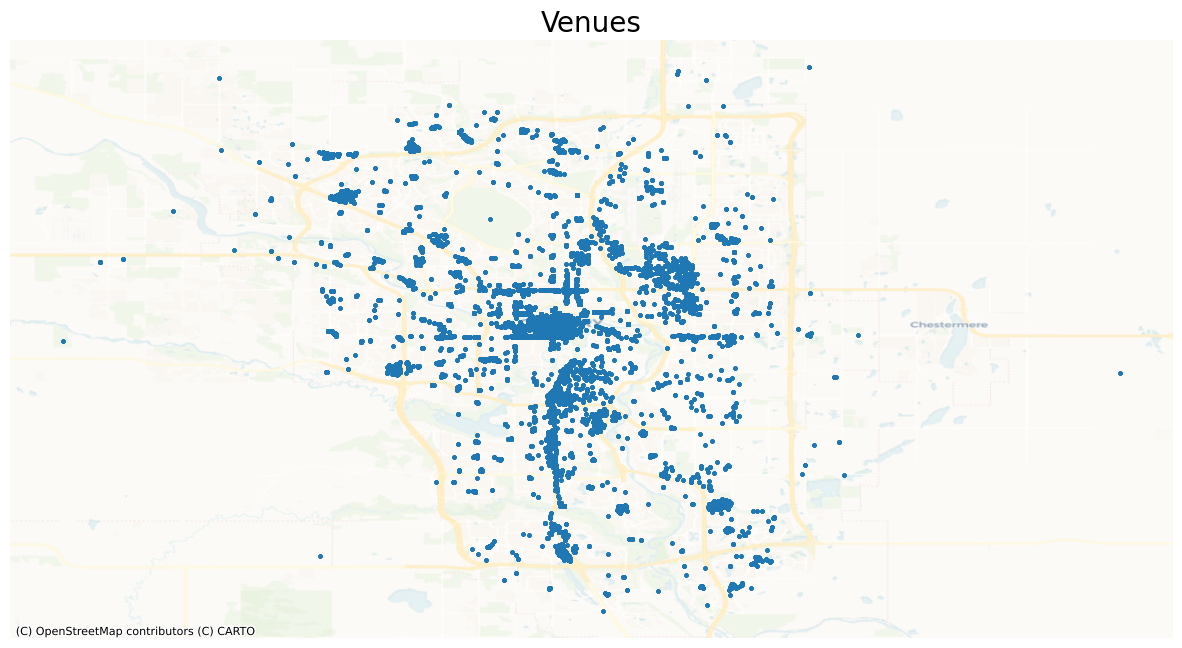

In [324]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')



calgary_gdf.plot(ax=ax,marker='o', markersize=5,legend=True)


# this adds the basemap
ctx.add_basemap(ax, crs=calgary_gdf.crs, alpha=0.6, source=ctx.providers.CartoDB.Voyager)

# this sets the title
ax.set_title("Venues",fontsize= 20)

# this removes the axis
ax.set_axis_off()

In [325]:
calgary_gdf["polarity"] = None

for rate in range(len(calgary_gdf["stars_y"])):
    if calgary_gdf["stars_y"][rate] > 3:
        calgary_gdf["polarity"][rate] = 1
    else:
        calgary_gdf["polarity"][rate] = 0

In [326]:
calgary_gdf.head()

business_id                            name  latitude  \
0  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
1  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
2  MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.94596   
3  rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.08499   
4  rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.08499   

    longitude  review_count  \
0 -114.037207             3   
1 -114.037207             3   
2 -114.037207             3   
3 -113.989605             5   
4 -113.989605             5   

                                          categories  \
0            Contractors, Landscaping, Home Services   
1            Contractors, Landscaping, Home Services   
2            Contractors, Landscaping, Home Services   
3  Shopping, Caterers, Furniture Stores, Hot Tub ...   
4  Shopping, Caterers, Furniture Stores, Hot Tub ...   

                                               hours               review_id  \
0  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  pltqT0DnejbWN-K32BD1Fg   
1  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  8Iaf1YXNjo3zPd6-uLSJhg   
2  {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...  fTU0yYLj78NJftEKah-woQ   
3  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...  2SGfqlKDjuFpXZ7LjdNJSQ   
4  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...  5RfnOMsGcQ26EoXlteFOyw   

                  user_id  stars_y  ...  cool  \
0  v6zuRbp5jjHroawRiv9IhQ      5.0  ...     0   
1  UkL35C-EXA_yje4HeNINeQ      5.0  ...     0   
2  CXhdG2DP0aplOZPZtNFobw      5.0  ...     0   
3  siNu6MF02MSMnoyPkaxZyg      5.0  ...     0   
4  -InhDRRVG7wrwsgAUvN4Qw      5.0  ...     3   

                                                text                 date  \
0  David came in the spring to give me an estimat...  2017-08-16 01:10:52   
1  Chinook Landscaping is a Company that I would ...  2014-06-15 21:09:06   
2  Chinook Landscaping is tops in my book\nI was ...  2013-08-22 22:10:38   
3  If you are looking for a supplier of games tab...  2009-06-29 02:20:25   
4  SML is now a personal wet dream of mine, the e...  2009-12-03 17:29:51   

       column1      column2           column3         column4  year  \
0  Contractors  Landscaping     Home Services             NaN  2017   
1  Contractors  Landscaping     Home Services             NaN  2014   
2  Contractors  Landscaping     Home Services             NaN  2013   
3     Shopping     Caterers  Furniture Stores  Hot Tub & Pool  2009   
4     Shopping     Caterers  Furniture Stores  Hot Tub & Pool  2009   

                      geometry polarity  
0  POINT (-114.03721 50.94596)        1  
1  POINT (-114.03721 50.94596)        1  
2  POINT (-114.03721 50.94596)        1  
3  POINT (-113.98961 51.08499)        1  
4  POINT (-113.98961 51.08499)        1  

[5 rows x 22 columns]

In [327]:
calgary_gdf["polarity"] = calgary_gdf["polarity"].astype('int')

In [328]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

restaurants_gdf = gpd.GeoDataFrame(
    restaurants, 
    geometry=gpd.points_from_xy(restaurants.longitude, 
                                      restaurants.latitude)).set_crs(epsg=4326)

restaurants_gdf

business_id                          name  \
1     -1u4Q4U6OZ-CvqoxUh7gKg                  Las Canarias   
2     -2C96suwzrE_cqI1U69cLA                   Open Sesame   
6     -7-uHFjQLH_uxPauYtd8iA         Prego Cucina Italiana   
15    -HhGpFRmOPxJuzmNTWHqhQ                     Sushi2you   
17    -Miw03v5yXJWjH9MN1aglw                      The Nash   
...                      ...                           ...   
3004  zYs33RJ3-Ply40HQdY9kbw               Oak Tree Tavern   
3007  z_BS6qapXMX1fA4ZLZ3jCA                   Dairy Queen   
3008  z_HWmTH5eR5iEJBfYsPvxg             East Side Mario's   
3023  zwFScgZRXOsWnucfwyn8pw  Nottinghams Pub & Restaurant   
3024  zxT_TuVfr_7OgGdZNyIwyw                Dublin Calling   

                        column1         column2                 column3  \
1                    Tapas Bars         Spanish      Tapas/Small Plates   
2                  Asian Fusion     Restaurants                Japanese   
6                     Wine Bars            Bars               Nightlife   
15                  Restaurants      Food Court              Sushi Bars   
17                    Nightlife  Canadian (New)             Restaurants   
...                         ...             ...                     ...   
3004                  Nightlife            Bars             Restaurants   
3007  Ice Cream & Frozen Yogurt            Food               Fast Food   
3008                Restaurants           Pizza  American (Traditional)   
3023                       Pubs     Restaurants  American (Traditional)   
3024                       Pubs       Irish Pub           Chicken Wings   

          column4   latitude   longitude  count  min  max  median      mean  \
1     Restaurants  51.037654 -114.088942     25  1.0  5.0     5.0  4.080000   
2       Nightlife  50.992148 -114.070811     74  1.0  5.0     4.0  3.445946   
6     Restaurants  51.052572 -114.068347     17  1.0  5.0     4.0  3.647059   
15       Japanese  51.075125 -113.956028      5  1.0  5.0     5.0  3.400000   
17           Bars  51.041415 -114.037001    128  1.0  5.0     4.0  3.906250   
...           ...        ...         ...    ...  ...  ...     ...       ...   
3004         Pubs  51.052903 -114.085536     40  1.0  5.0     4.0  3.800000   
3007  Restaurants  51.013744 -114.132804      4  1.0  2.0     1.0  1.250000   
3008      Italian  50.906484 -114.066818     22  1.0  5.0     2.0  2.454545   
3023      Burgers  51.116559 -114.204570     22  1.0  5.0     4.0  3.409091   
3024  Restaurants  51.038428 -114.141595      5  2.0  3.0     2.0  2.200000   

                         geometry  
1     POINT (-114.08894 51.03765)  
2     POINT (-114.07081 50.99215)  
6     POINT (-114.06835 51.05257)  
15    POINT (-113.95603 51.07512)  
17    POINT (-114.03700 51.04141)  
...                           ...  
3004  POINT (-114.08554 51.05290)  
3007  POINT (-114.13280 51.01374)  
3008  POINT (-114.06682 50.90648)  
3023  POINT (-114.20457 51.11656)  
3024  POINT (-114.14159 51.03843)  

[839 rows x 14 columns]

In [329]:
restaurants_gdf["polarity"] = np.where(restaurants_gdf['mean'] > 3, 1, 0)

#restaurants_gdf["polarity"] = restaurants_gdf["polarity"].astype('int')

restaurants_gdf


business_id                          name  \
1     -1u4Q4U6OZ-CvqoxUh7gKg                  Las Canarias   
2     -2C96suwzrE_cqI1U69cLA                   Open Sesame   
6     -7-uHFjQLH_uxPauYtd8iA         Prego Cucina Italiana   
15    -HhGpFRmOPxJuzmNTWHqhQ                     Sushi2you   
17    -Miw03v5yXJWjH9MN1aglw                      The Nash   
...                      ...                           ...   
3004  zYs33RJ3-Ply40HQdY9kbw               Oak Tree Tavern   
3007  z_BS6qapXMX1fA4ZLZ3jCA                   Dairy Queen   
3008  z_HWmTH5eR5iEJBfYsPvxg             East Side Mario's   
3023  zwFScgZRXOsWnucfwyn8pw  Nottinghams Pub & Restaurant   
3024  zxT_TuVfr_7OgGdZNyIwyw                Dublin Calling   

                        column1         column2                 column3  \
1                    Tapas Bars         Spanish      Tapas/Small Plates   
2                  Asian Fusion     Restaurants                Japanese   
6                     Wine Bars            Bars               Nightlife   
15                  Restaurants      Food Court              Sushi Bars   
17                    Nightlife  Canadian (New)             Restaurants   
...                         ...             ...                     ...   
3004                  Nightlife            Bars             Restaurants   
3007  Ice Cream & Frozen Yogurt            Food               Fast Food   
3008                Restaurants           Pizza  American (Traditional)   
3023                       Pubs     Restaurants  American (Traditional)   
3024                       Pubs       Irish Pub           Chicken Wings   

          column4   latitude   longitude  count  min  max  median      mean  \
1     Restaurants  51.037654 -114.088942     25  1.0  5.0     5.0  4.080000   
2       Nightlife  50.992148 -114.070811     74  1.0  5.0     4.0  3.445946   
6     Restaurants  51.052572 -114.068347     17  1.0  5.0     4.0  3.647059   
15       Japanese  51.075125 -113.956028      5  1.0  5.0     5.0  3.400000   
17           Bars  51.041415 -114.037001    128  1.0  5.0     4.0  3.906250   
...           ...        ...         ...    ...  ...  ...     ...       ...   
3004         Pubs  51.052903 -114.085536     40  1.0  5.0     4.0  3.800000   
3007  Restaurants  51.013744 -114.132804      4  1.0  2.0     1.0  1.250000   
3008      Italian  50.906484 -114.066818     22  1.0  5.0     2.0  2.454545   
3023      Burgers  51.116559 -114.204570     22  1.0  5.0     4.0  3.409091   
3024  Restaurants  51.038428 -114.141595      5  2.0  3.0     2.0  2.200000   

                         geometry  polarity  
1     POINT (-114.08894 51.03765)         1  
2     POINT (-114.07081 50.99215)         1  
6     POINT (-114.06835 51.05257)         1  
15    POINT (-113.95603 51.07512)         1  
17    POINT (-114.03700 51.04141)         1  
...                           ...       ...  
3004  POINT (-114.08554 51.05290)         1  
3007  POINT (-114.13280 51.01374)         0  
3008  POINT (-114.06682 50.90648)         0  
3023  POINT (-114.20457 51.11656)         1  
3024  POINT (-114.14159 51.03843)         0  

[839 rows x 15 columns]

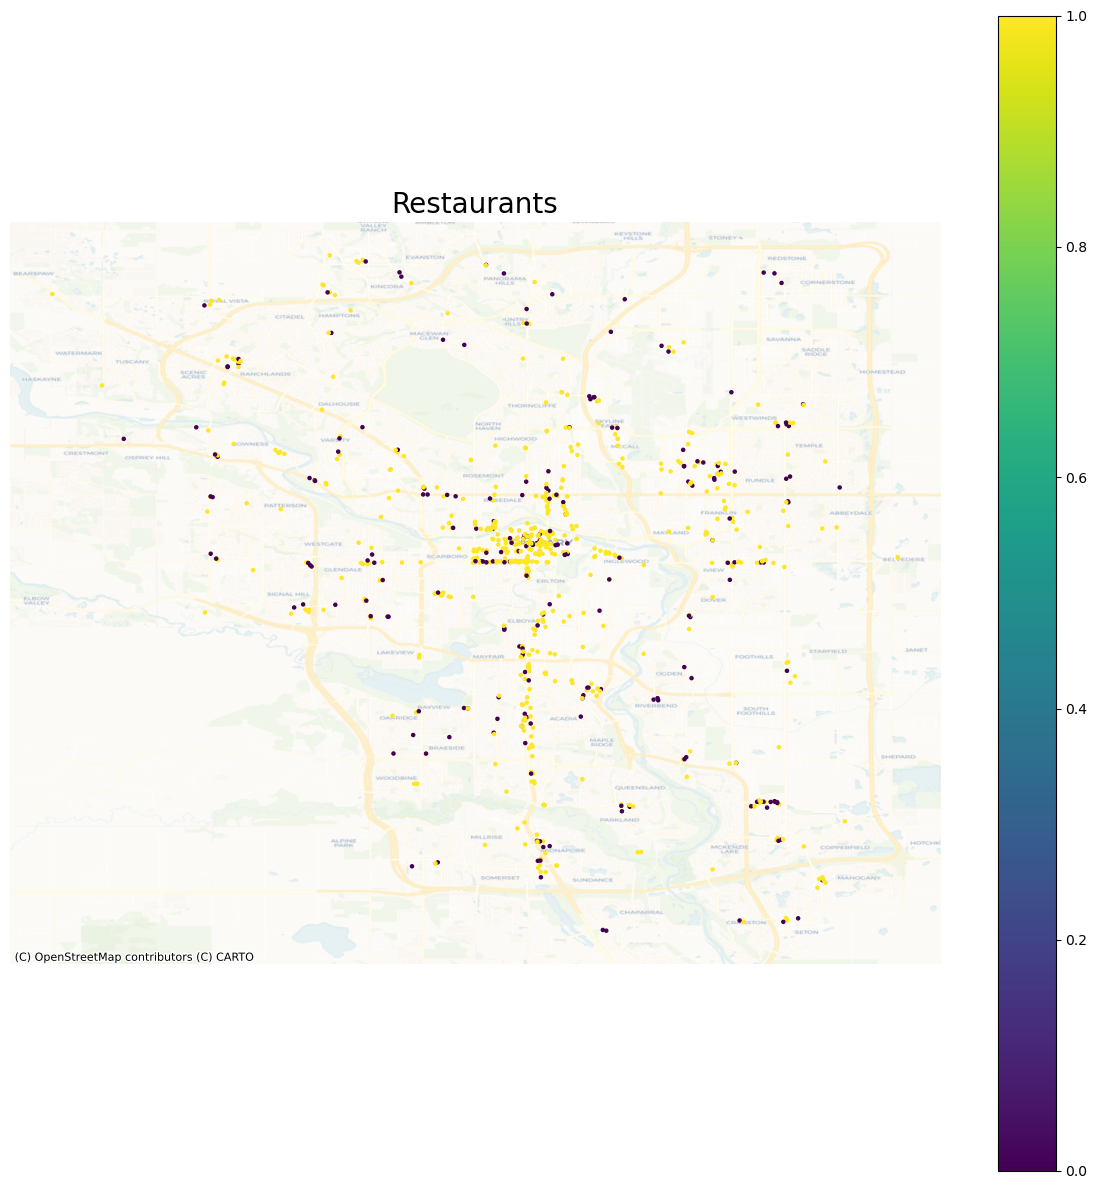

In [330]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')


restaurants_gdf.plot(ax=ax,marker='o', column= "polarity",markersize=5,legend=True)


# this adds the basemap
ctx.add_basemap(ax, crs=calgary_gdf.crs, alpha=0.6, source=ctx.providers.CartoDB.Voyager)

# this sets the title
ax.set_title("Restaurants",fontsize= 20)

# this removes the axis
ax.set_axis_off()

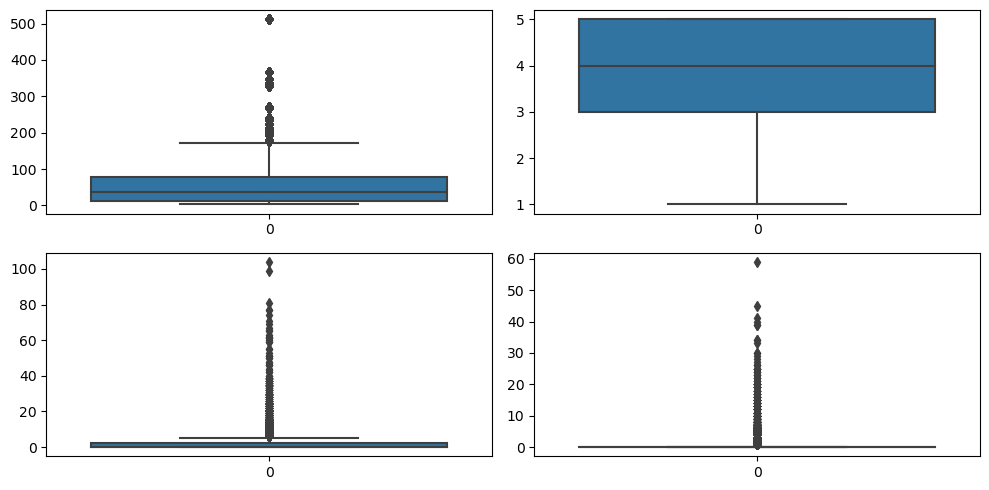

In [331]:
#have a look at outliers of price, total floor area, number of rooms and current energy efficiency

fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(calgary_gdf['review_count'], ax = axs[0,0])
plt2 = sns.boxplot(calgary_gdf['stars_y'], ax = axs[0,1])
plt3 = sns.boxplot(calgary_gdf['useful'], ax = axs[1,0])
plt4 = sns.boxplot(calgary_gdf['funny'], ax = axs[1,1])

plt.tight_layout()

In [404]:
#look at how many houses have more than ten rooms
(calgary_gdf["review_count"] > 200).value_counts()



False    77309
True      4873
Name: review_count, dtype: int64

In [416]:
#calculate housing price outliers

Q1 = calgary_gdf["review_count"].quantile(0.25)
Q3 = calgary_gdf["review_count"].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

#calculate housing price outliers

filter1 = (calgary_gdf["review_count"] <= Q1 - 1.5 * IQR) | (calgary_gdf["review_count"] >= Q3 + 1.5 *IQR)

#create a gdf including only outliers

outliers = calgary_gdf[filter1 == True]


calgary_gdf_withoutoutliers = calgary_gdf[filter1 == False]

outliers

business_id                          name   latitude  \
3066   EZ3vflgYwoBAJDrhc0TCbw  Hayden Block Smoke & Whiskey  51.052655   
3067   EZ3vflgYwoBAJDrhc0TCbw  Hayden Block Smoke & Whiskey  51.052655   
3068   EZ3vflgYwoBAJDrhc0TCbw  Hayden Block Smoke & Whiskey  51.052655   
3069   EZ3vflgYwoBAJDrhc0TCbw  Hayden Block Smoke & Whiskey  51.052655   
3070   EZ3vflgYwoBAJDrhc0TCbw  Hayden Block Smoke & Whiskey  51.052655   
...                       ...                           ...        ...   
80769  B9Qt4Eyk3lpz2LEtGU205g              Cactus Club Cafe  51.089517   
80770  B9Qt4Eyk3lpz2LEtGU205g              Cactus Club Cafe  51.089517   
80771  B9Qt4Eyk3lpz2LEtGU205g              Cactus Club Cafe  51.089517   
80772  B9Qt4Eyk3lpz2LEtGU205g              Cactus Club Cafe  51.089517   
80773  B9Qt4Eyk3lpz2LEtGU205g              Cactus Club Cafe  51.089517   

        longitude  review_count  \
3066  -114.088296           177   
3067  -114.088296           177   
3068  -114.088296           177   
3069  -114.088296           177   
3070  -114.088296           177   
...           ...           ...   
80769 -114.000813           177   
80770 -114.000813           177   
80771 -114.000813           177   
80772 -114.000813           177   
80773 -114.000813           177   

                                              categories  \
3066   Nightlife, Barbeque, Restaurants, Bars, Whiske...   
3067   Nightlife, Barbeque, Restaurants, Bars, Whiske...   
3068   Nightlife, Barbeque, Restaurants, Bars, Whiske...   
3069   Nightlife, Barbeque, Restaurants, Bars, Whiske...   
3070   Nightlife, Barbeque, Restaurants, Bars, Whiske...   
...                                                  ...   
80769  Canadian (New), Cocktail Bars, Restaurants, Ni...   
80770  Canadian (New), Cocktail Bars, Restaurants, Ni...   
80771  Canadian (New), Cocktail Bars, Restaurants, Ni...   
80772  Canadian (New), Cocktail Bars, Restaurants, Ni...   
80773  Canadian (New), Cocktail Bars, Restaurants, Ni...   

                                                   hours  \
3066   {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...   
3067   {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...   
3068   {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...   
3069   {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...   
3070   {'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ...   
...                                                  ...   
80769  {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...   
80770  {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...   
80771  {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...   
80772  {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...   
80773  {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...   

                    review_id                 user_id  stars_y  ...  \
3066   tCIyek7ktmCFQW3TY70sRw  A4bpHuvzaQt9-XAg8e9Msw      4.0  ...   
3067   Sx6OhaF557RYd3N18OIkzg  brd33PD_6nqK_VVnO3NWAg      5.0  ...   
3068   TPaJF3PokYqQN8rG1D_spg  R5Ab6TcorcES3jiQ6BiiDQ      5.0  ...   
3069   ms9yJpAhYGC-FYFfJ2i2sg  Z5r70En-h8IGz2xWiPxnQg      4.0  ...   
3070   _djyUVYzJIpH27W6E_0pPw  130UUjfFfVyvAMTN1p2npg      4.0  ...   
...                       ...                     ...      ...  ...   
80769  radJF4C_UGBU1XtkiiF-aQ  ABRH3A37M24GrCR3-bX1Pw      5.0  ...   
80770  z6L7Qk8SMA8jSXEi9WUUZg  Nhzu39a-thKikoYUAGrLbg      5.0  ...   
80771  -IJKiInW57yvx53abs1gCA  77-clznSALDVUdq7TDAhJQ      1.0  ...   
80772  gXlseVDZPrBo58Tl4xeP4g  S8A9AQWmYZfXsyHVTMKXGw      5.0  ...   
80773  jguEtlBgB5reLrPSmUZ_LQ  ErVfSvzGkEK2DVV_Dw4dmg      4.0  ...   

                                                    text                 date  \
3066   Oh my dear Brisket, you and I shall be togethe...  2017-02-09 05:57:14   
3067   there's nothing bad to say here. I can't even ...  2016-09-06 16:32:18   
3068   Love this place, some of the best BBQ and amaz...  2018-04-04 09:04:46   
3069   I've been here a couple times and I love their...  2017-08-08 20:11:26   
3070   S

In [417]:
calgary_gdf_withoutoutliers

business_id                            name   latitude  \
0      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
1      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
2      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
3      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
4      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
...                       ...                             ...        ...   
82177  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82178  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82179  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82180  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82181  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   

        longitude  review_count  \
0     -114.037207             3   
1     -114.037207             3   
2     -114.037207             3   
3     -113.989605             5   
4     -113.989605             5   
...           ...           ...   
82177 -114.066646             3   
82178 -114.066646             3   
82179 -114.012717             3   
82180 -114.012717             3   
82181 -114.012717             3   

                                              categories  \
0                Contractors, Landscaping, Home Services   
1                Contractors, Landscaping, Home Services   
2                Contractors, Landscaping, Home Services   
3      Shopping, Caterers, Furniture Stores, Hot Tub ...   
4      Shopping, Caterers, Furniture Stores, Hot Tub ...   
...                                                  ...   
82177                       Pest Control, Local Services   
82178                       Pest Control, Local Services   
82179                     Home Services, Home Inspectors   
82180                     Home Services, Home Inspectors   
82181                     Home Services, Home Inspectors   

                                                   hours  \
0      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
1      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
2      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
3      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
4      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
...                                                  ...   
82177  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82178  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82179  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82180  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82181  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   

                    review_id                 user_id  stars_y  ...  \
0      pltqT0DnejbWN-K32BD1Fg  v6zuRbp5jjHroawRiv9IhQ      5.0  ...   
1      8Iaf1YXNjo3zPd6-uLSJhg  UkL35C-EXA_yje4HeNINeQ      5.0  ...   
2      fTU0yYLj78NJftEKah-woQ  CXhdG2DP0aplOZPZtNFobw      5.0  ...   
3      2SGfqlKDjuFpXZ7LjdNJSQ  siNu6MF02MSMnoyPkaxZyg      5.0  ...   
4      5RfnOMsGcQ26EoXlteFOyw  -InhDRRVG7wrwsgAUvN4Qw      5.0  ...   
...                       ...                     ...      ...  ...   
82177  pd7i8sxkMfbjdWR926nz8Q  zYLF37lcx2MPIHZVJjahBA      5.0  ...   
82178  Uu4txscaQB25tF5kuG4gkg  rlY-ah6vhTHiRkJMEtDJ-g      5.0  ...   
82179  kooH5UmJ5k-8USDe03jI9Q  Id5k4kNeblkyQSuteVURGQ      1.0  ...   
82180  2SUoFTckEOdGd1V7GpIvrg  grsdpOuwSdwN3ndafhfa9Q      1.0  ...   
82181  _1cYlw_lCkStn-RXH2DIbw  5Hs29y5fO7a6ZXWQmUbPaw      1.0  ...   

                                                    text                 date  \
0      David came in the spring to give me an estimat...  2017-08-16 01:10:52   
1      Chinook Landscaping is a Company that I would ...  2014-06-15 21:09:06   
2      Chinook Landscaping is tops in my book\nI was ...  2013-08-22 22:10:38   
3      If you are looking for a supplier of games tab...  2009-06

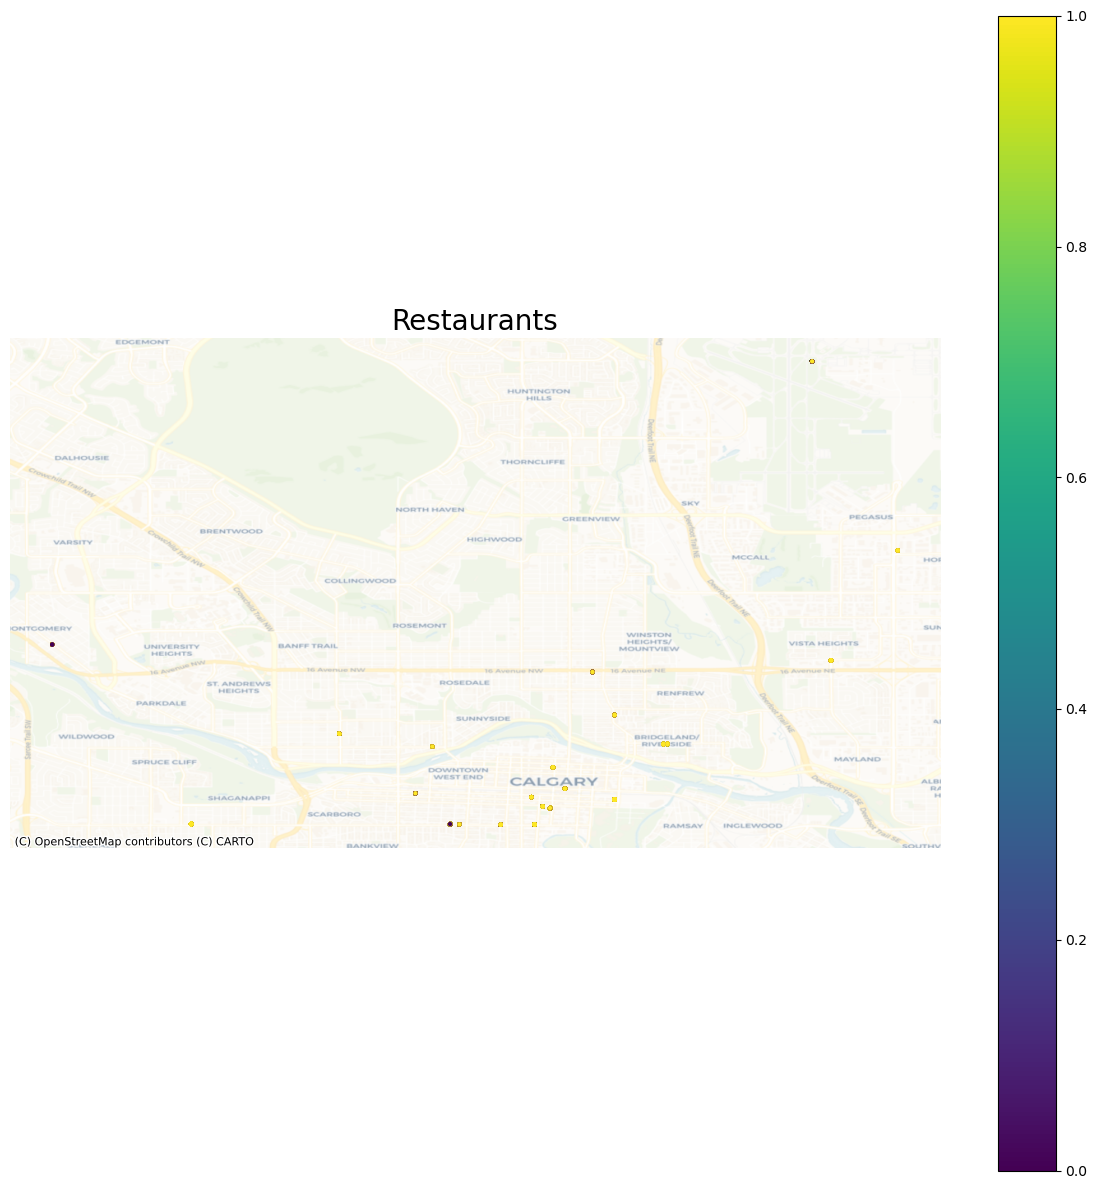

In [413]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')


outliers.plot(ax=ax,marker='o', column= "polarity",markersize=5,legend=True)


# this adds the basemap
ctx.add_basemap(ax, crs=calgary_gdf.crs, alpha=0.6, source=ctx.providers.CartoDB.Voyager)

# this sets the title
ax.set_title("Restaurants",fontsize= 20)

# this removes the axis
ax.set_axis_off()

In [415]:
outliers_group =outliers.groupby("business_id")["stars_y"].agg(["count",min,max,"median","mean"]).reset_index()
outliers_group

business_id  count  min  max  median      mean
0   5aK167zvZhGs_i7Vf4A1NQ    518  1.0  5.0     5.0  4.480695
1   7DjrTaEIa-7x3o-Trp2Htw    217  1.0  5.0     4.0  4.304147
2   8dnH_PcGlzECcCGk_5yyww    202  1.0  5.0     4.0  4.064356
3   9tgJbLfCQcZ35-TSabZOfA    245  1.0  5.0     4.0  4.204082
4   ARH8diyhBtiSgRR4_7oxmg    183  1.0  5.0     4.0  3.590164
5   B9Qt4Eyk3lpz2LEtGU205g    181  1.0  5.0     5.0  4.392265
6   CE7hNKYS6gIMKv6jK429uQ    214  1.0  5.0     4.0  4.228972
7   DqSTQWhRU3WKdIN2b_Nzog    180  1.0  5.0     5.0  4.116667
8   EZ3vflgYwoBAJDrhc0TCbw    178  1.0  5.0     5.0  4.325843
9   GGxnlrfvWy7LFvjN5z_z3w    337  1.0  5.0     4.0  4.089021
10  KMjpXsJFNiqE18orsi4stQ    350  1.0  5.0     3.0  3.205714
11  KSSOnRQ1YSciCIkR-qOR4A    232  1.0  5.0     4.0  3.905172
12  Qtu-zIwz4TDUu1U7oxCgHg    239  1.0  5.0     4.0  3.962343
13  SKhV8mF40RcsGrJjkuEwvw    374  1.0  5.0     5.0  4.532086
14  SYCgakqaEBTjRhOVFXjV3g    251  1.0  5.0     4.0  4.007968
15  YpoIDLyRGhgciExGAHRQcw    351  1.0  5.0     4.0  4.111111
16  iAhAnPxgKb6fzxrEcoHtlw    206  1.0  5.0     5.0  4.446602
17  kmOeRAvOL1oR6Z-4Ggdx6w    335  1.0  5.0     4.0  4.000000
18  llad5ng0sxHkWrK1ZlswxA    244  1.0  5.0     5.0  4.643443
19  tWjfgVtTD5n01Cq9dFWGsA    215  1.0  5.0     4.0  3.544186
20  tXoO9Uc_tQ8_IqTmEQcW5w    272  1.0  5.0     5.0  4.566176
21  v1C8WQR6iB0WW0W48T5pqA    273  1.0  5.0     4.0  3.406593

<AxesSubplot: xlabel='stars_y', ylabel='count'>

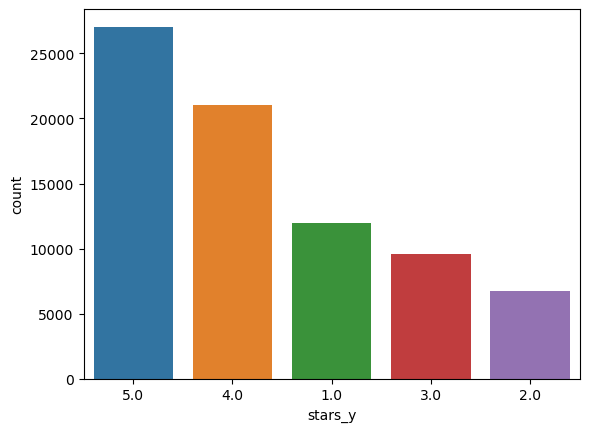

In [418]:

sns.countplot(calgary_gdf_withoutoutliers,
              x='stars_y',
              order=calgary_gdf["stars_y"].value_counts().index)

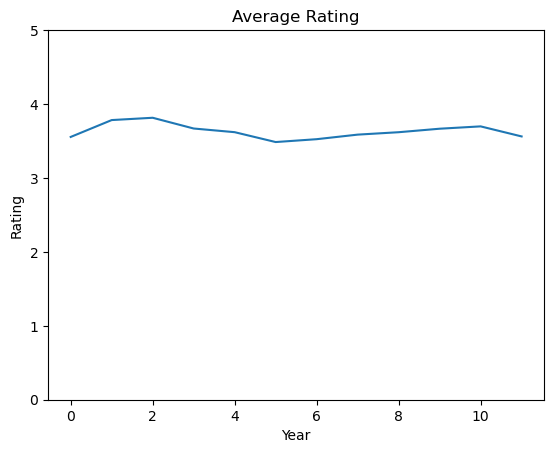

In [420]:


plt.plot(calgary_year['mean'])
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Rating')
plt.ylim(0,5)
plt.show()

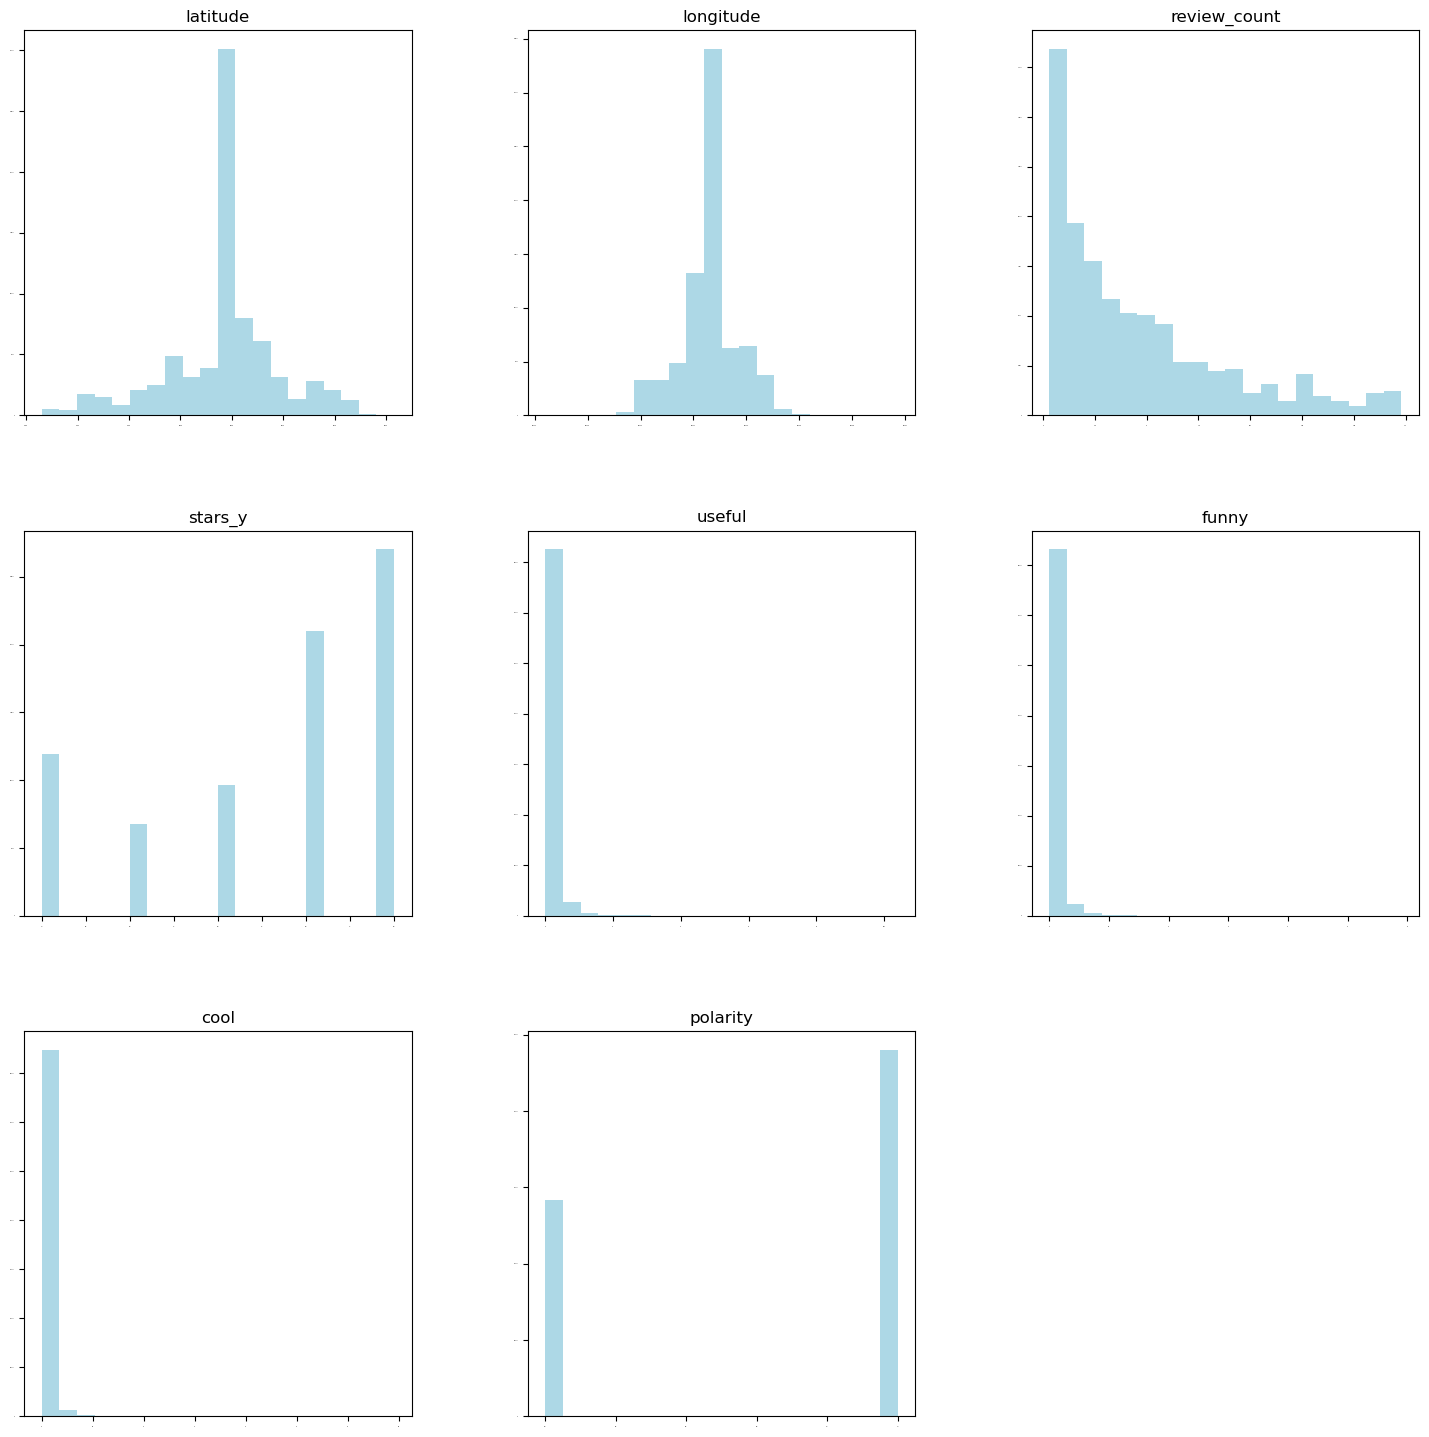

In [421]:
calgary_gdf_withoutoutliers.hist(bins=20,
       figsize=(18,18), 
       color='lightblue', 
       xlabelsize=0, 
       ylabelsize=0, 
       grid=False
      )
plt.show()

In [422]:
#grouping housing price values by London boroughs 

group =calgary_gdf_withoutoutliers.groupby(["business_id","name","latitude","longitude"])["review_count"].agg(["count",min,max,"median","mean"]).reset_index()
group

business_id                           name   latitude  \
0     --1UhMGODdWsrMastO9DZw               The Spicy Amigos  51.049673   
1     --YPwqIlRJrhHkJcjY3eiA           That Old Retro Store  51.041015   
2     -0RU0vASJOV383dYA8VZgA               Pho Hoan Pasteur  50.898863   
3     -1u4Q4U6OZ-CvqoxUh7gKg                   Las Canarias  51.037654   
4     -2C96suwzrE_cqI1U69cLA                    Open Sesame  50.992148   
...                      ...                            ...        ...   
5207  zwEHPvXH0H-ZjRP-MkIdmw                 Salon Luminous  51.015451   
5208  zwFScgZRXOsWnucfwyn8pw   Nottinghams Pub & Restaurant  51.116559   
5209  zxT_TuVfr_7OgGdZNyIwyw                 Dublin Calling  51.038428   
5210  zxl5OV08TBaEg43X3p7_Ng  Acclaim Hotel Calgary Airport  51.150411   
5211  zz2AP9CHRvSZbpLey10UeQ               Soban Korean BBQ  51.049496   

       longitude  count  min  max  median  mean  
0    -114.079977     29   27   27    27.0  27.0  
1    -114.033419      3    3    3     3.0   3.0  
2    -113.941861     15   15   15    15.0  15.0  
3    -114.088942     25   25   25    25.0  25.0  
4    -114.070811     74   73   73    73.0  73.0  
...          ...    ...  ...  ...     ...   ...  
5207 -114.175243      4    4    4     4.0   4.0  
5208 -114.204570     22   21   21    21.0  21.0  
5209 -114.141595      5    4    4     4.0   4.0  
5210 -113.999658     24   24   24    24.0  24.0  
5211 -114.061191     33   33   33    33.0  33.0  

[5212 rows x 9 columns]

In [423]:
group["count"].median()

6.0

In [425]:
calgary_gdf[calgary_gdf["review_count"]>101].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15230 entries, 755 to 81915
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   business_id     15230 non-null  object  
 1   name            15230 non-null  object  
 2   latitude        15230 non-null  float64 
 3   longitude       15230 non-null  float64 
 4   review_count    15230 non-null  int64   
 5   categories      15230 non-null  object  
 6   hours           15230 non-null  object  
 7   review_id       15230 non-null  object  
 8   user_id         15230 non-null  object  
 9   stars_y         15230 non-null  float64 
 10  useful          15230 non-null  int64   
 11  funny           15230 non-null  int64   
 12  cool            15230 non-null  int64   
 13  text            15230 non-null  object  
 14  date            15230 non-null  object  
 15  column1         15230 non-null  object  
 16  column2         15230 non-null  object  
 17  co

In [426]:
group_stars =calgary_gdf_withoutoutliers.groupby(["business_id","name","latitude","longitude","polarity","review_count"])["stars_y"].agg(["count",min,max,"median","mean"]).reset_index()
group_stars

business_id                           name   latitude  \
0     --1UhMGODdWsrMastO9DZw               The Spicy Amigos  51.049673   
1     --1UhMGODdWsrMastO9DZw               The Spicy Amigos  51.049673   
2     --YPwqIlRJrhHkJcjY3eiA           That Old Retro Store  51.041015   
3     --YPwqIlRJrhHkJcjY3eiA           That Old Retro Store  51.041015   
4     -0RU0vASJOV383dYA8VZgA               Pho Hoan Pasteur  50.898863   
...                      ...                            ...        ...   
9359  zxT_TuVfr_7OgGdZNyIwyw                 Dublin Calling  51.038428   
9360  zxl5OV08TBaEg43X3p7_Ng  Acclaim Hotel Calgary Airport  51.150411   
9361  zxl5OV08TBaEg43X3p7_Ng  Acclaim Hotel Calgary Airport  51.150411   
9362  zz2AP9CHRvSZbpLey10UeQ               Soban Korean BBQ  51.049496   
9363  zz2AP9CHRvSZbpLey10UeQ               Soban Korean BBQ  51.049496   

       longitude  polarity  review_count  count  min  max  median      mean  
0    -114.079977         0            27      6  1.0  3.0     2.0  2.000000  
1    -114.079977         1            27     23  4.0  5.0     5.0  4.608696  
2    -114.033419         0             3      2  1.0  1.0     1.0  1.000000  
3    -114.033419         1             3      1  4.0  4.0     4.0  4.000000  
4    -113.941861         0            15      6  1.0  3.0     1.5  1.833333  
...          ...       ...           ...    ...  ...  ...     ...       ...  
9359 -114.141595         0             4      5  2.0  3.0     2.0  2.200000  
9360 -113.999658         0            24      6  1.0  3.0     1.5  1.833333  
9361 -113.999658         1            24     18  4.0  5.0     5.0  4.555556  
9362 -114.061191         0            33     14  1.0  3.0     2.0  1.785714  
9363 -114.061191         1            33     19  4.0  5.0     4.0  4.473684  

[9364 rows x 11 columns]

In [427]:
#convert df into gdf using easting and northings 
#project the gdf into British National Grid (27700)

group_stars_gdf = gpd.GeoDataFrame(
    group_stars, 
    geometry=gpd.points_from_xy(group_stars.longitude, 
                                      group_stars.latitude)).set_crs(epsg=4326)

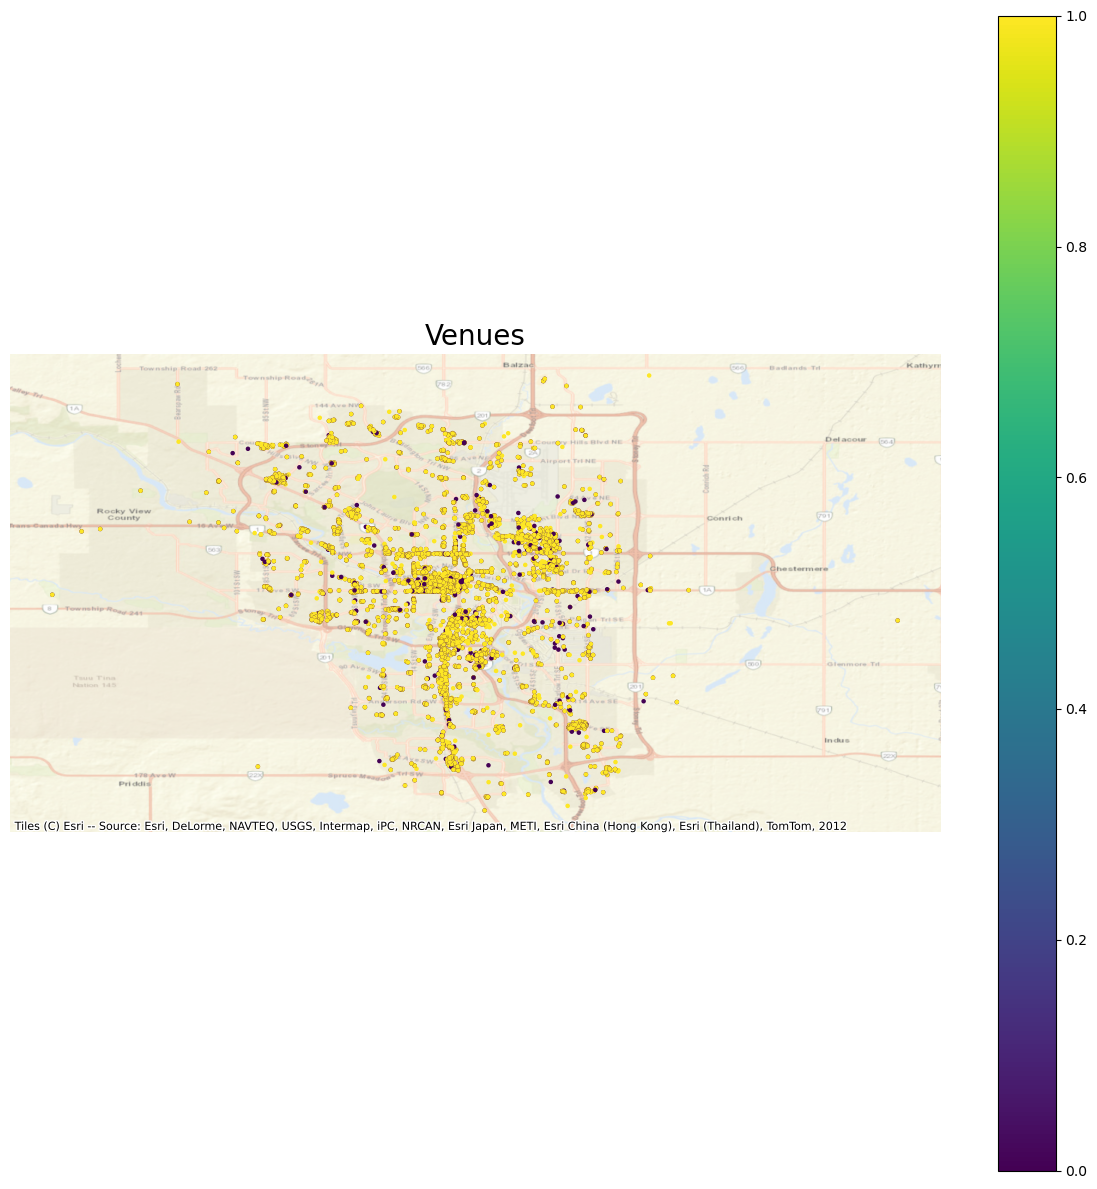

In [428]:
#mapping housing price distribution in London without dealing with outliers

fig, ax = plt.subplots(figsize=(15, 15))


ax.set_aspect('equal')


group_stars_gdf.plot(ax=ax,marker='o',column="polarity", markersize=5,legend=True)

ctx.add_basemap(ax, crs=group_stars_gdf.crs, alpha=0.6, source=ctx.providers.Esri.WorldStreetMap)


# this sets the title
ax.set_title("Venues",fontsize= 20)

# this removes the axis
ax.set_axis_off()

https://www.analyticsvidhya.com/blog/2022/10/using-text-mining-on-reviews-data-to-generate-business-insights/

In [476]:
import string
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize, blankline_tokenize


#https://stackoverflow.com/questions/57030670/how-to-remove-punctuation-and-numbers-during-tweettokenizer-step-in-nlp

def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

calgary_gdf_withoutoutliers['text_processed']=calgary_gdf_withoutoutliers['text'].apply(clean_text)

def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in string.punctuation]
    stopw = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopw]
    tokens = [word for word in tokens if len(word)>=3]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens] 
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text



calgary_gdf_withoutoutliers['text_processed']=calgary_gdf_withoutoutliers['text_processed'].apply(preprocessing)
calgary_gdf_withoutoutliers['text_processed'] = calgary_gdf_withoutoutliers['text_processed'].str.lower()
text_1 = calgary_gdf_withoutoutliers['text_processed'].values

In [477]:

def remove_non_latin(text):
    """
    Removes non-Latin characters from text using regular expressions.
    """
    latin_only = re.sub(r'[^\x00-\x7F]+', '', text)
    return latin_only

# Apply the function to the 'text' column
calgary_gdf_withoutoutliers['text_processed']  = calgary_gdf_withoutoutliers['text_processed'].apply(remove_non_latin)

In [478]:
calgary_gdf_withoutoutliers

business_id                            name   latitude  \
0      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
1      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
2      MbZMmwo-eL0Jnm_Yb9KJrA  Chinook Landscaping and Design  50.945960   
3      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
4      rdg0b0tHKvSCQNl6u3tS_A               SML Entertainment  51.084990   
...                       ...                             ...        ...   
82177  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82178  knifdfgaeWZ-277S6lsSnA           Martin's Pest Control  50.905732   
82179  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82180  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   
82181  Q4-TlHSvl45XMg2Y1wEVJQ                      Home-Alyze  51.099332   

        longitude  review_count  \
0     -114.037207             3   
1     -114.037207             3   
2     -114.037207             3   
3     -113.989605             5   
4     -113.989605             5   
...           ...           ...   
82177 -114.066646             3   
82178 -114.066646             3   
82179 -114.012717             3   
82180 -114.012717             3   
82181 -114.012717             3   

                                              categories  \
0                Contractors, Landscaping, Home Services   
1                Contractors, Landscaping, Home Services   
2                Contractors, Landscaping, Home Services   
3      Shopping, Caterers, Furniture Stores, Hot Tub ...   
4      Shopping, Caterers, Furniture Stores, Hot Tub ...   
...                                                  ...   
82177                       Pest Control, Local Services   
82178                       Pest Control, Local Services   
82179                     Home Services, Home Inspectors   
82180                     Home Services, Home Inspectors   
82181                     Home Services, Home Inspectors   

                                                   hours  \
0      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
1      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
2      {'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...   
3      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
4      {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
...                                                  ...   
82177  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82178  {'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...   
82179  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82180  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   
82181  {'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...   

                    review_id                 user_id  stars_y  ...  \
0      pltqT0DnejbWN-K32BD1Fg  v6zuRbp5jjHroawRiv9IhQ      5.0  ...   
1      8Iaf1YXNjo3zPd6-uLSJhg  UkL35C-EXA_yje4HeNINeQ      5.0  ...   
2      fTU0yYLj78NJftEKah-woQ  CXhdG2DP0aplOZPZtNFobw      5.0  ...   
3      2SGfqlKDjuFpXZ7LjdNJSQ  siNu6MF02MSMnoyPkaxZyg      5.0  ...   
4      5RfnOMsGcQ26EoXlteFOyw  -InhDRRVG7wrwsgAUvN4Qw      5.0  ...   
...                       ...                     ...      ...  ...   
82177  pd7i8sxkMfbjdWR926nz8Q  zYLF37lcx2MPIHZVJjahBA      5.0  ...   
82178  Uu4txscaQB25tF5kuG4gkg  rlY-ah6vhTHiRkJMEtDJ-g      5.0  ...   
82179  kooH5UmJ5k-8USDe03jI9Q  Id5k4kNeblkyQSuteVURGQ      1.0  ...   
82180  2SUoFTckEOdGd1V7GpIvrg  grsdpOuwSdwN3ndafhfa9Q      1.0  ...   
82181  _1cYlw_lCkStn-RXH2DIbw  5Hs29y5fO7a6ZXWQmUbPaw      1.0  ...   

                                                    text                 date  \
0      David came in the spring to give me an estimat...  2017-08-16 01:10:52   
1      Chinook Landscaping is a Company that I would ...  2014-06-15 21:09:06   
2      Chinook Landscaping is tops in my book\nI was ...  2013-08-22 22:10:38   
3      If you are looking for a supplier of games tab...  2009-06

In [433]:
text_1.shape

(76385,)

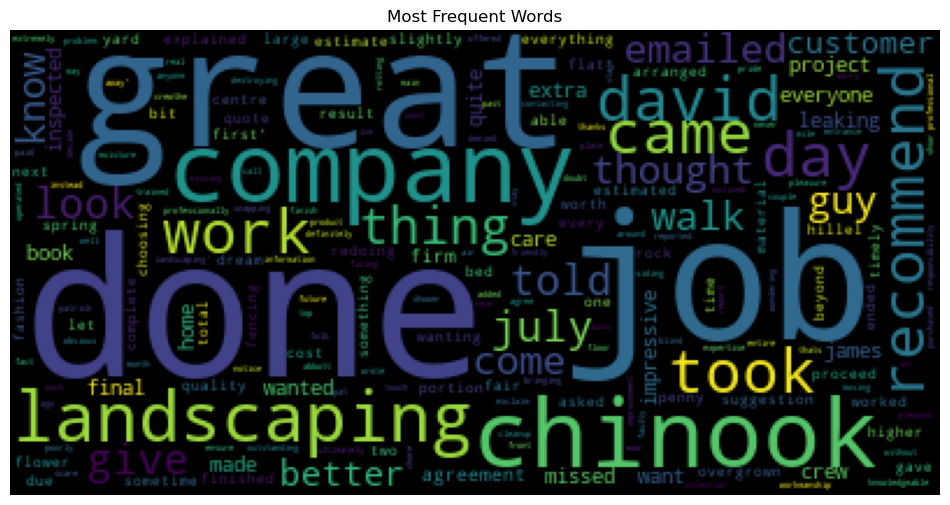

In [479]:
wordcloud = WordCloud().generate(str(text_1))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

In [435]:
# Extract frequent word pair bigrams from training data
tokens = []
for sentence in calgary_gdf_withoutoutliers['text_processed']:
    tokens.extend(nltk.word_tokenize(sentence))
bigrams = list(nltk.bigrams(tokens))
freq_dist = nltk.FreqDist(bigrams)
freq_bigrams = [bigram for bigram, frequency in freq_dist.most_common(2500)]  # Example: top 10 frequent bigrams

# Vectorize training and test data using frequent word pair bigrams as features
vectorizer = CountVectorizer(ngram_range=(2, 2), vocabulary=set(freq_bigrams))


X1 = vectorizer.fit_transform(calgary_gdf_withoutoutliers['text_processed'])



In [436]:
freq_bigrams

[('the', 'food'),
 ('customer', 'service'),
 ('this', 'place'),
 ('the', 'service'),
 ('first', 'time'),
 ('could', "n't"),
 ('the', 'staff'),
 ('come', 'back'),
 ('would', "n't"),
 ('really', 'good'),
 ('highly', 'recommend'),
 ("n't", 'even'),
 ("n't", 'know'),
 ('pretty', 'good'),
 ('ice', 'cream'),
 ('next', 'time'),
 ('even', 'though'),
 ('food', 'good'),
 ("n't", 'get'),
 ('great', 'place'),
 ('great', 'service'),
 ('feel', 'like'),
 ("'ve", 'ever'),
 ('they', 'also'),
 ('staff', 'friendly'),
 ('would', 'recommend'),
 ('every', 'time'),
 ('make', 'sure'),
 ('good', 'food'),
 ('service', 'great'),
 ('great', 'food'),
 ('going', 'back'),
 ("n't", 'want'),
 ('the', 'place'),
 ('service', 'good'),
 ('good', 'the'),
 ('food', 'great'),
 ("'ve", 'never'),
 ('one', 'best'),
 ('would', 'definitely'),
 ('good', 'service'),
 ('definitely', 'back'),
 ('coming', 'back'),
 ("n't", 'think'),
 ('the', 'price'),
 ('friendly', 'staff'),
 ('love', 'place'),
 ('look', 'like'),
 ('long', 'time'),
 (

In [438]:
# this gets the training set and vectorise it
X_train, X_test, y_train, y_test = train_test_split(X1, calgary_gdf_withoutoutliers['polarity'],
                                                    test_size=0.30,
                                                    stratify=calgary_gdf_withoutoutliers['polarity'],
                                                    random_state = 35)
X_train.shape

(53469, 2500)

In [439]:

from sklearn.tree import DecisionTreeClassifier

# Train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the trained classifier on test data
predictions = clf.predict(X_test)
print(accuracy_score(y_test,predictions))

0.6292110315936463


## 3.2.2 Build a supervised learning model for text analysis

In [480]:
import nltk
from nltk.stem import WordNetLemmatizer

# word n-gram (default)
vectorizer = CountVectorizer(analyzer='word',lowercase=True, min_df=2, stop_words='english',max_features=5000)
X = vectorizer.fit_transform(calgary_gdf_withoutoutliers["text_processed"])

wor = vectorizer.get_feature_names_out()


bag_of_words = pd.DataFrame(X.toarray(),columns=[wor])

X

<76385x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 2976590 stored elements in Compressed Sparse Row format>

In [481]:
wor

array(['ability', 'able', 'absolute', ..., 'zone', 'zoo', 'zucchini'],
      dtype=object)

https://www.geeksforgeeks.org/flipkart-reviews-sentiment-analysis-using-python/?ref=rp

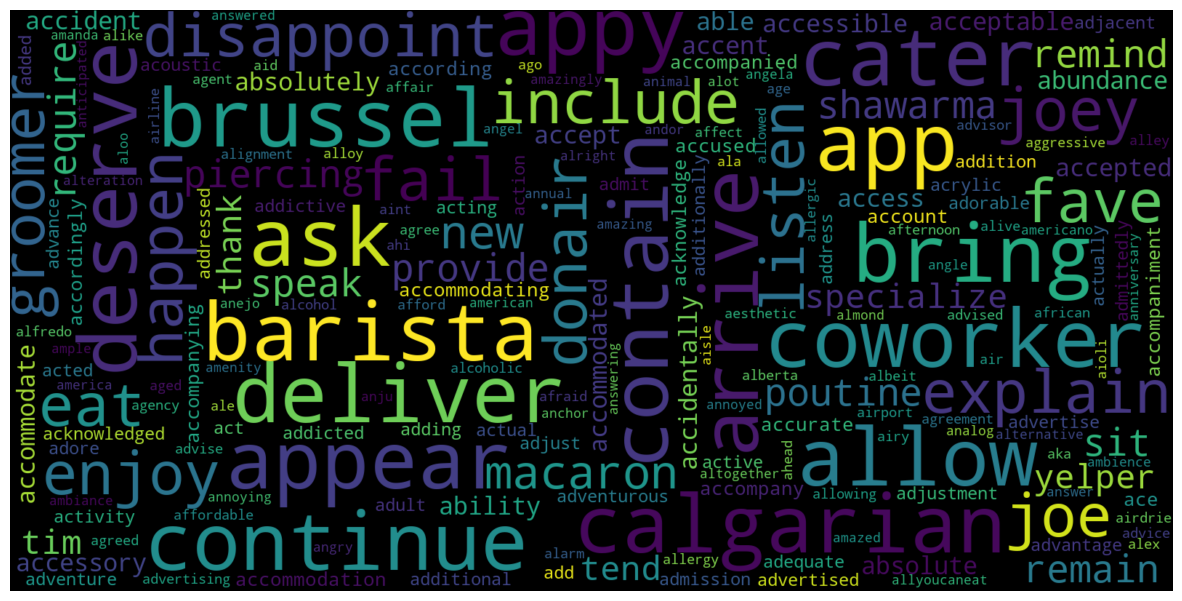

In [482]:
consolidated = ' '.join(
    word for word in wor.astype(str))
wordCloud = WordCloud(width=1600, height=800,
                      random_state=21, max_font_size=110)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [483]:
# this gets the training set and vectorise it
X_train, X_test, y_train, y_test = train_test_split(X, calgary_gdf_withoutoutliers['polarity'],
                                                    test_size=0.30,
                                                    stratify=calgary_gdf_withoutoutliers['polarity'],
                                                    random_state = 42)
X_train

<53469x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 2077913 stored elements in Compressed Sparse Row format>

In [489]:
from sklearn.tree import DecisionTreeClassifier
  
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
  
#testing the model
pred = model.predict(X_test)
print(accuracy_score(y_test,pred))

0.755192878338279


In [484]:
# this fit the Naive Bayes Classifier
m_clf = MultinomialNB()
m_clf.fit(X_train,y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = m_clf.predict(X_test)

# this prints the f1_score 
print (f1_score(y_test, y_pred, average='macro'))
print (accuracy_score(y_test, y_pred))

0.8166906872064328
0.8329551405131785


<AxesSubplot: >

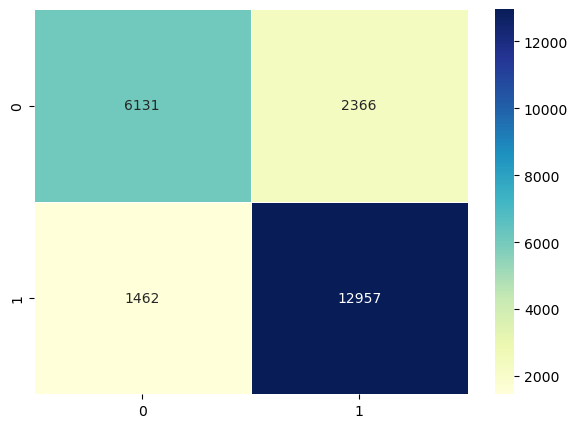

In [485]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#creates a grid to plot on
f, ax = plt.subplots(figsize=(7, 5))
#plots confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")

In [486]:
#creates a new logistic regression model
model = LogisticRegression()
#fits (/configures) this model using the training data
model.fit(X_train, y_train)

#then tries to make a prediction using the test dataset's x-variables
y_pred=model.predict(X_test)
y_pred[0:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0])

In [487]:
#reports the prediction accuracy of the testset
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_test, y_pred),3)))

the out of sample test accuracy is : 0.867


In [488]:
#reports the prediction accuracy of the trainset
y_pred_train=model.predict(X_train)
print ('the out of sample test accuracy is : '+ str(round(accuracy_score(y_train, y_pred_train),3)))

the out of sample test accuracy is : 0.909


In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVC_clf = SVC(kernel='linear')
SVC_clf.fit(X_train,y_train)
y_pred = SVC_clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

In [453]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 40],
    'n_estimators': [100, 200, 300]# restricted the grid search to reduce compute time 
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

In [454]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 40],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [455]:
model = grid_search.best_estimator_
y_pred=model.predict(X_test)
print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred),3)))

the out of sample test accuracy for a RandomForestClassifier is : 0.829
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   8.5s
[CV] END .....................max_depth=40, n_estimators=100; total time=  45.4s
[CV] END .....................max_depth=40, n_estimators=100; total time=  17.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=   8.4s
[CV] END .....................max_depth=40, n_estimators=100; total time=  45.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=   8.6s
[CV] END .....................max_depth=40, n_estimators=200; total time= 1.4min
[CV] END .....................max_depth=10, n_estimators=200; total time=   8.8s
[CV] END .....................max_depth=40, n_estimators=200; total time= 1.4min
[CV] END .....................max_depth=10, n_estimators=300; total time=  13.1s
[CV] END .....................max_dep

In [462]:
# this gets the top 300 features 

tfid_vectorizer = TfidfVectorizer(max_df=0.95, 
                                min_df=2, 
                                stop_words='english')

# fit the tfidf vectoriser
tf=tfid_vectorizer.fit_transform(calgary_gdf_withoutoutliers["text_processed"])

ttfid_vectorizer.get_feature_names()

#tfid.shape

In [463]:
# this gets the training set and vectorise it
X_train, X_test, y_train, y_test = train_test_split(tf, calgary_gdf_withoutoutliers['polarity'],
                                                    test_size=0.30,
                                                    stratify=calgary_gdf_withoutoutliers['polarity'],
                                                    random_state = 42)
X_train

<53469x32657 sparse matrix of type '<class 'numpy.float64'>'
	with 2265253 stored elements in Compressed Sparse Row format>

In [464]:
# this fit the Naive Bayes Classifier
m_clf = MultinomialNB()
m_clf.fit(X_train,y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = m_clf.predict(X_test)

# this prints the f1_score 
print (f1_score(y_test, y_pred, average='macro'))
print (accuracy_score(y_test, y_pred))

0.7970972688091733
0.8260603944842032


## Word Embeddings (word2vector)

In [456]:
import gensim
from gensim.models import Word2Vec
import nltk
import numpy as np

import gensim.downloader


In [457]:
wv = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
f'the vocab size of this pretrain word2vec model is: {len(wv)}'

In [458]:
vector = wv['king']  # get numpy vector of a word
print (f'the size of word vector is {len(vector)}.')

the size of word vector is 300.


## Topic Modelling

In [490]:
from sklearn.decomposition import LatentDirichletAllocation

In [491]:
def plot_top_words(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [498]:
import nltk
from nltk.stem import WordNetLemmatizer

# word n-gram (default)
vectorizer = CountVectorizer(analyzer='word',lowercase=True, min_df=2, stop_words='english')
X = vectorizer.fit_transform(calgary_gdf_withoutoutliers["text_processed"])

wor = vectorizer.get_feature_names_out()


bag_of_words = pd.DataFrame(X.toarray(),columns=[wor])

X

<76385x32984 sparse matrix of type '<class 'numpy.int64'>'
	with 3240710 stored elements in Compressed Sparse Row format>

In [499]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(X)


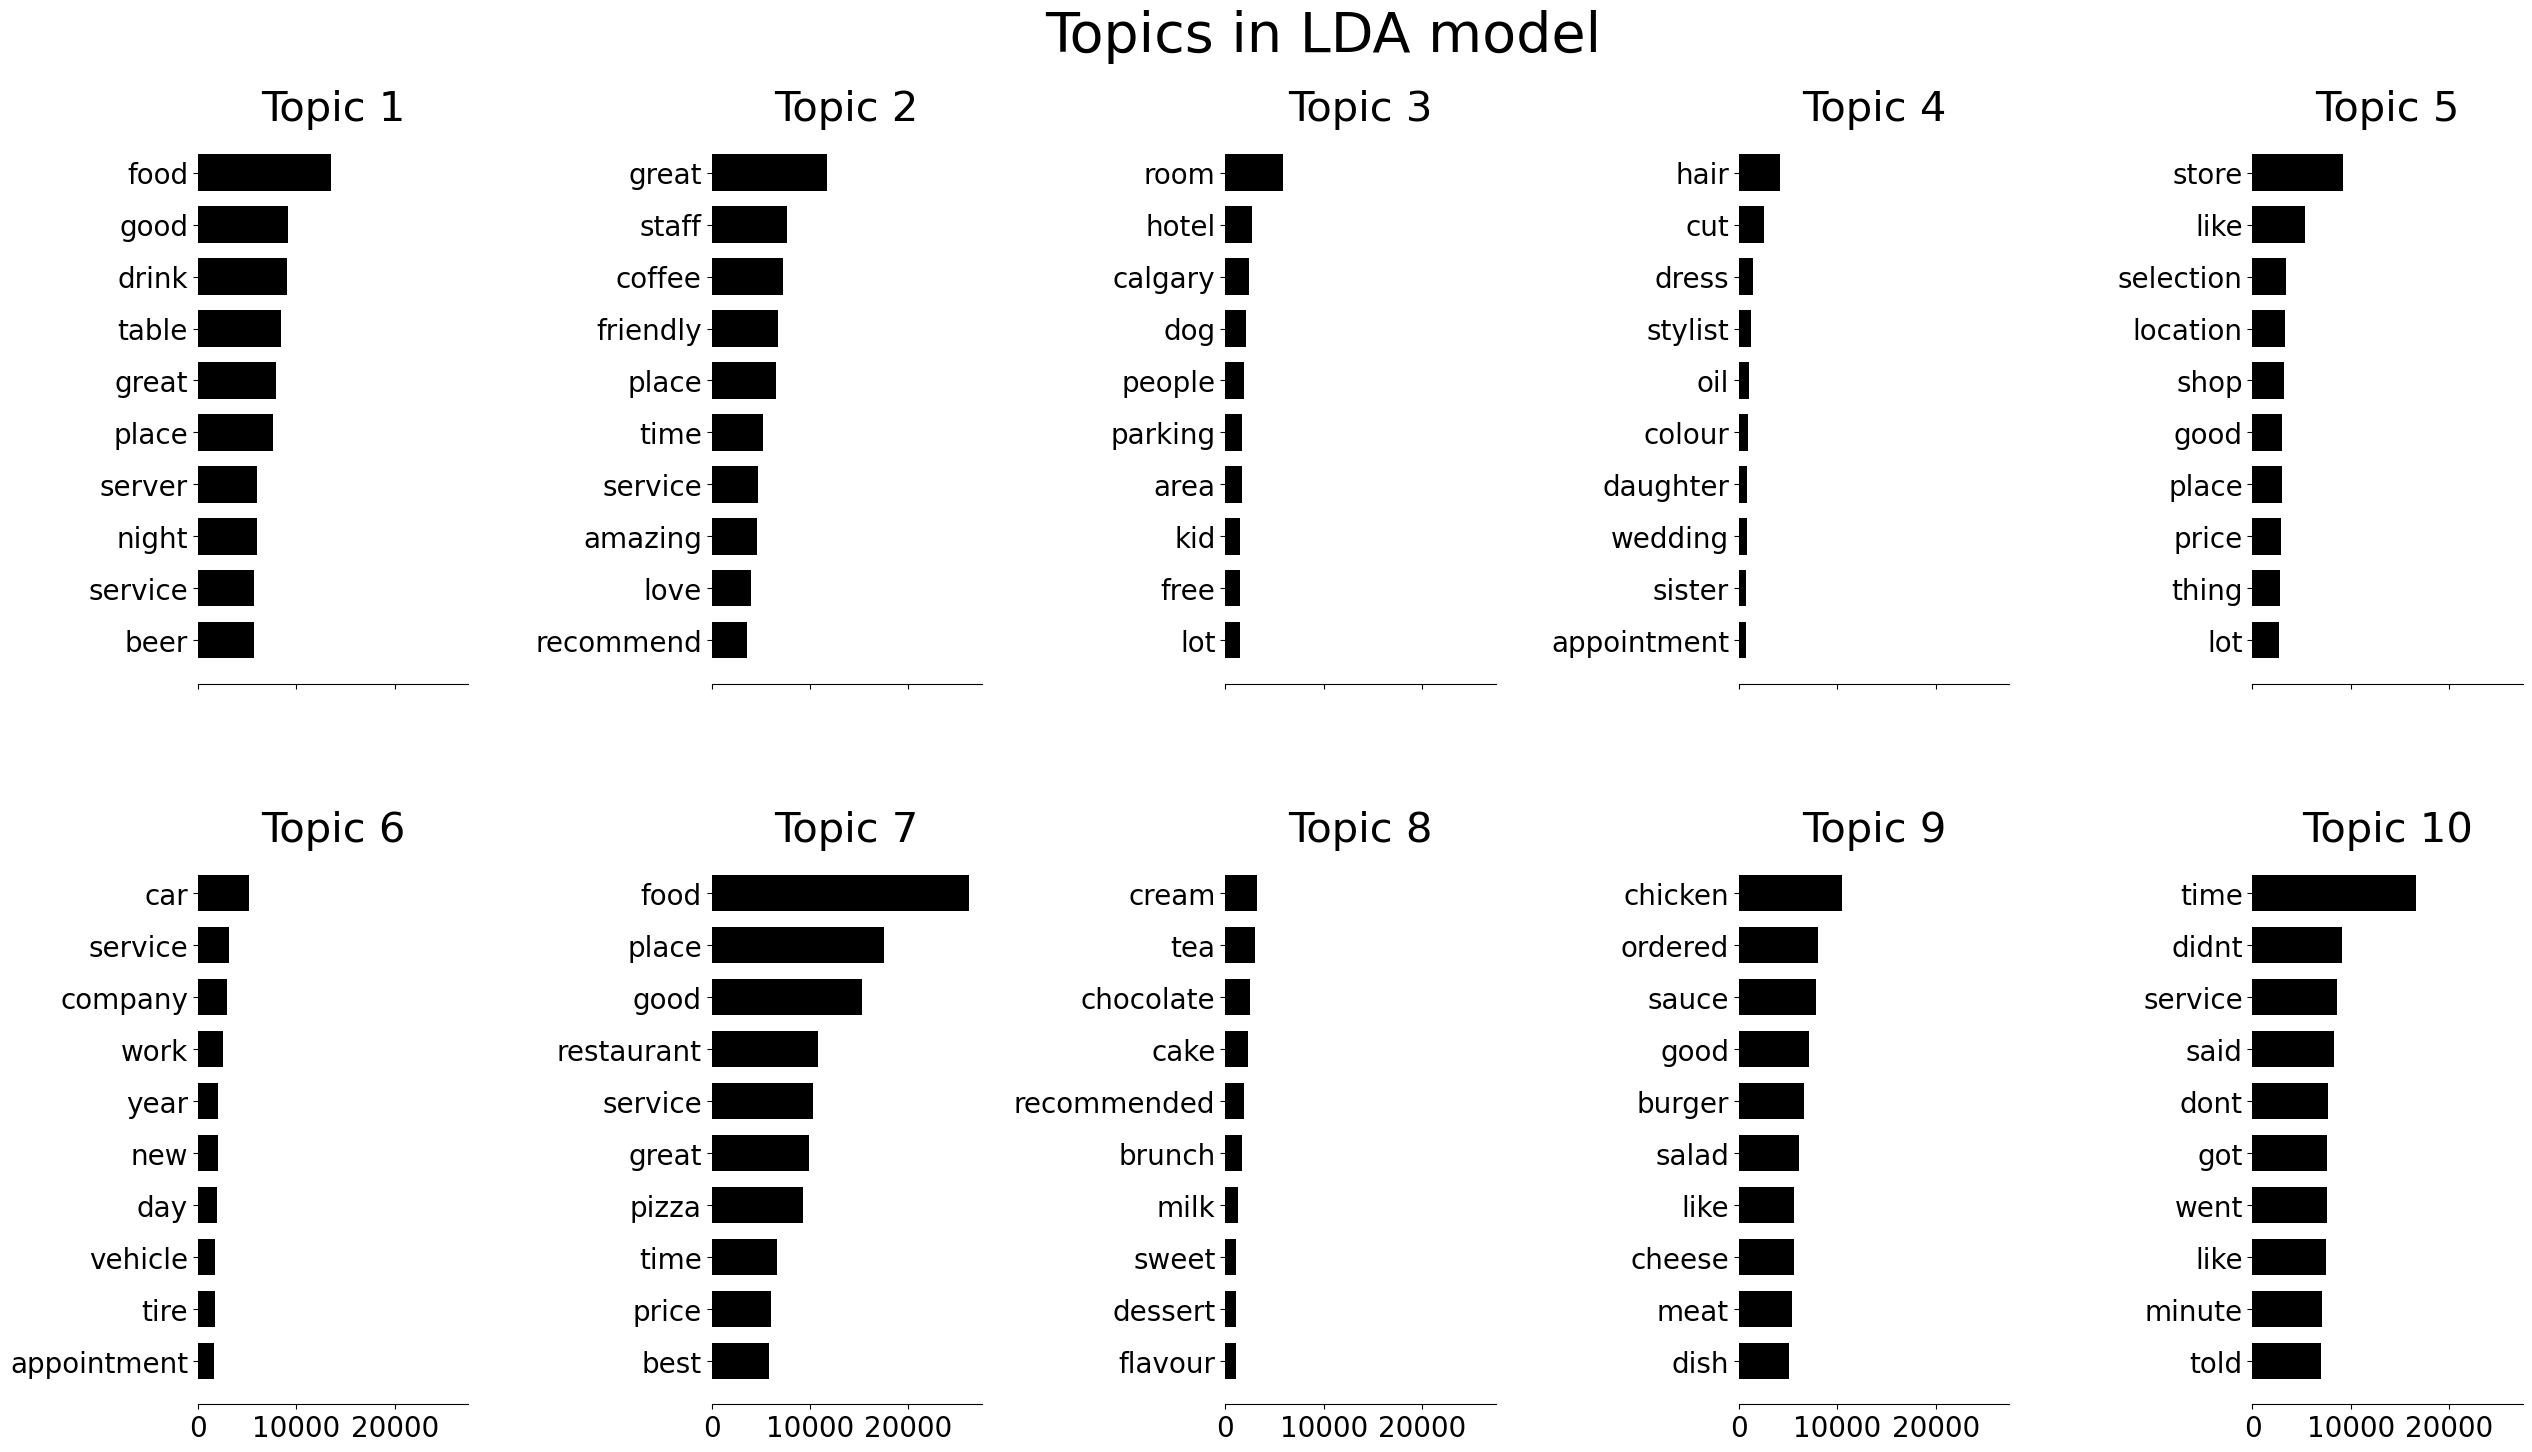

In [500]:
# plot top words
no_top_words = 10
plot_top_words(lda, wor, no_top_words, 'Topics in LDA model')